## Tarea 3 - Física Computacional
**Román Tamez Vidal Tamayo Tamez** - (tamoaltas)

In [1]:
import math as m
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

In [9]:
import matplotlib
# Para el formato de las gráficas
matplotlib.rcParams.update(
    {
        "font.family": "serif",
        "text.usetex": True,
        "pgf.rcfonts": False,
        "axes.unicode_minus": False,
        "font.size": 12,
        "pgf.preamble": "\n".join([ # Aún más formato
        r"\usepackage[utf8]{inputenc}",
        r"\usepackage[T1]{fontenc}",
        ])
    }
)

### Problema 1:
Implementación de métodos de integración

Realice un notebook en el que se expliquen y programen los siguientes algoritmos de integración de ecuaciones diferenciales:

- **Método de Euler**
- **Serie de Taylor de segundo orden**
- **Runge-Kutta de segundo orden**
- **Runge-Kutta de cuarto orden**

Verifique el funcionamiento de sus integradores encontrando la solución de la siguiente ecuación diferencial para $ x(t) $:

$$
\ddot{x} + 0.5 \dot{x} + \sin x = e^{-t} (\sin(3t) + \cos(2t))
$$

Con condiciones iniciales $ \dot{x}(0) = 1 $ y $ x(0) = 0 $.

In [ ]:
def sistema_edo_1(t, y):
    # y = [x, v] donde v = dx/dt
    x, v = y
    dvdt = -0.5 * v - np.sin(x) + np.exp(-t) * (np.sin(3*t) + np.cos(2*t))
    return np.array([v, dvdt])

In [6]:
def euler_step(f, t, y, h):
    """
    Realiza un paso del método de Euler.
    f: función que representa la EDO (sistema de primer orden)
    t: tiempo actual
    y: estado actual
    h: tamaño de paso
    """
    return y + h * f(t, y)

In [7]:
def integrar_euler(f, t0, y0, tf, h):
    """
    Integra la EDO usando el método de Euler.
    f: función que define el sistema
    t0: tiempo inicial
    y0: condiciones iniciales
    tf: tiempo final
    h: tamaño de paso
    """
    t_values = np.arange(t0, tf, h)
    y_values = np.zeros((len(t_values), len(y0)))
    
    y_values[0] = y0
    for i in range(1, len(t_values)):
        y_values[i] = euler_step(f, t_values[i-1], y_values[i-1], h)
    
    return t_values, y_values

In [ ]:
def EDO_Euler(g,x0,t):
    #para un sistema autonomo
    h , sol = t[1]-t[0] , np.zeros( (len(x0),len(t)) )
    sol[:,0] = x0 #condicion inicial
    for i in range(len(t)-1):
        sol[:,i+1] = sol[:,i] + h*g(sol[:,i])
    return sol


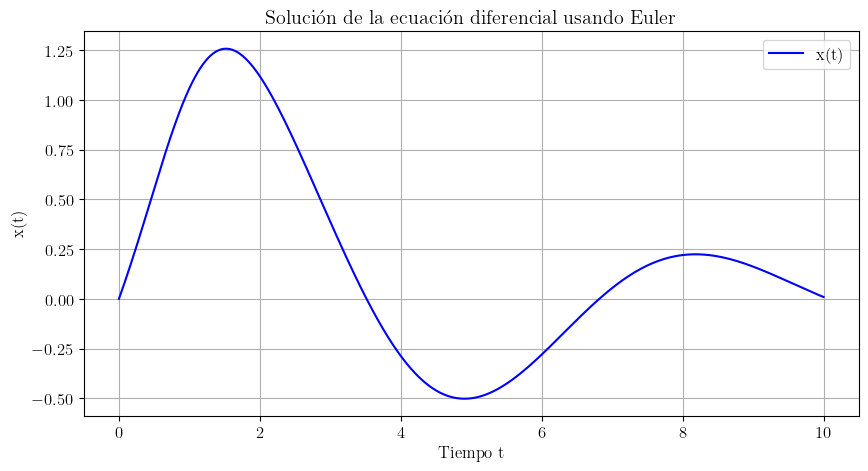

In [8]:
# Condiciones iniciales
t0, tf = 0, 10  # Tiempo inicial y final
h = 0.01  # Paso de tiempo
y0 = np.array([0, 1])  # x(0) = 0, v(0) = 1

# Integración
t_values, y_values = integrar_euler(sistema_edo, t0, y0, tf, h)

# Graficar resultado
plt.figure(figsize=(10, 5))
plt.plot(t_values, y_values[:, 0], label='x(t)', color='b')
plt.xlabel('Tiempo t')
plt.ylabel('x(t)')
plt.title('Solución de la ecuación diferencial usando Euler')
plt.legend()
plt.grid()
plt.show()